In [7]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# These functions are used to simulate homeogeneous European and African
# samples based on Gutenkunst et als. out of africa model using msprime

import msprime
import math
import pandas as pd
import numpy as np

def out_of_africa(N_CEU, N_YRI, rmap, N_CHB=0, chrom=22):
        """
        This function is copied from the msprime documentation. It is used to
        simulate African, European, and Asian individuals based on the Out of
        Africa model developed by Gutenkunst et al. from the HapMap data

        Parameters
        ----------
        N_CEU : int
                Number of samples of European ancestry
        N_YRI : int
                Number of samples of African ancestry
        rmap : msprime.simulations.RecombinationMap
                Recombination map for a reference chromosome
        N_CHB : int, optional
                Number of samples of Asian ancestry
        chrom : str, optional
                Chromosome number of rmap file

        Returns
        -------
        tskit.trees.TreeSequence
                Tree object from which sample haplotypes can be
                accessed
        """
    # First we set out the maximum likelihood values of the various parameters
    # given in Table 1.
        N_A = 7300
        N_B = 2100
        N_AF = 12300
        N_EU0 = 1000
        N_AS0 = 510
        # Times are provided in years, so we convert into generations.
        generation_time = 25
        T_AF = 220e3 / generation_time
        T_B = 140e3 / generation_time
        T_EU_AS = 21.2e3 / generation_time
        # We need to work out the starting (diploid) population sizes based on
        # the growth rates provided for these two populations
        r_EU = 0.004
        r_AS = 0.0055
        N_EU = N_EU0 / math.exp(-r_EU * T_EU_AS)
        N_AS = N_AS0 / math.exp(-r_AS * T_EU_AS)
        # Migration rates during the various epochs.
        m_AF_B = 25e-5
        m_AF_EU = 3e-5
        m_AF_AS = 1.9e-5
        m_EU_AS = 9.6e-5
        # Population IDs correspond to their indexes in the population
        # configuration array. Therefore, we have 0=YRI, 1=CEU and 2=CHB
        # initially.
        population_configurations = [
            msprime.PopulationConfiguration(
                sample_size=(2*N_YRI), initial_size=N_AF),
            msprime.PopulationConfiguration(
                sample_size=(2*N_CEU), initial_size=N_EU, growth_rate=r_EU),
            msprime.PopulationConfiguration(
                sample_size=N_CHB, initial_size=N_AS, growth_rate=r_AS)
        ]
        migration_matrix = [
            [      0, m_AF_EU, m_AF_AS],
            [m_AF_EU,       0, m_EU_AS],
            [m_AF_AS, m_EU_AS,       0],
        ]
        demographic_events = [
            # CEU and CHB merge into B with rate changes at T_EU_AS
            msprime.MassMigration(
                time=T_EU_AS, source=2, destination=1, proportion=1.0),
            msprime.MigrationRateChange(time=T_EU_AS, rate=0),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(0, 1)),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(1, 0)),
            msprime.PopulationParametersChange(
                time=T_EU_AS, initial_size=N_B, growth_rate=0, population_id=1),
            # Population B merges into YRI at T_B
            msprime.MassMigration(
                time=T_B, source=1, destination=0, proportion=1.0),
            # Size changes to N_A at T_AF
            msprime.PopulationParametersChange(
                time=T_AF, initial_size=N_A, population_id=0)
        ]
        tree = msprime.simulate(mutation_rate=2e-8,
                                recombination_map=rmap,
                                population_configurations=population_configurations,
                                migration_matrix=migration_matrix,
                                demographic_events=demographic_events,
                                model="dtwf")
        return tree

In [11]:
rmap = msprime.RecombinationMap.read_hapmap("../data/genetic_map_GRCh37_chr22.txt")

In [ ]:
out_of_africa(10, 10,rmap)

In [24]:
train_test_eur = h5py.File("../results/sim1/train_test_m_500_h2_0.67_EXTRA_new_rand_env.hdf5","r")

In [25]:
list(train_test_eur.attrs)

['liability_thresh']

In [26]:
train_test_eur.keys()

KeysView(<HDF5 file "train_test_m_500_h2_0.67_EXTRA_new_rand_env.hdf5" (mode r)>)

In [27]:
yri_true_prs = h5py.File("../results/sim1/yri_prs_m_500_h2_0.67.hdf5","r")

In [28]:
yri_true_prs.keys()

KeysView(<HDF5 file "yri_prs_m_500_h2_0.67.hdf5" (mode r)>)

In [29]:
import seaborn as sns

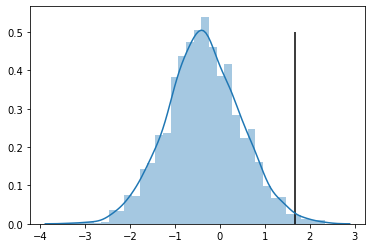

In [31]:
sns.distplot(yri_true_prs["G"][()][:2000])
plt.vlines(train_test.attrs["liability_thresh"],0,0.5)

plt.show()

In [35]:
G = yri_true_prs["G"][()][:2000]


In [37]:
e = np.random.normal(loc=0, scale=(1-0.67), size=int(G.shape[0]))
Ze = (e - np.mean(e))/np.std(e)
E = np.sqrt(1-0.67)*Ze

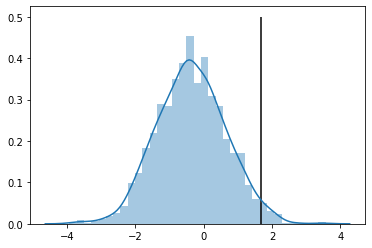

In [39]:
sns.distplot(G+E)
plt.vlines(train_test.attrs["liability_thresh"],0,0.5)
plt.show()

In [41]:
0.05*2000

100.0

In [44]:
len((G+E)[(G+E) > train_test.attrs["liability_thresh"]])

47